# ResOpsBR: attributes
***

**Autor:** Chus Casado Rodríguez<br>
**Fecha:** 17-07-2025<br>

**Introduction:**<br>
This code compares the available attributes for reservoirs in Brazil from different sources: the Brazilian Ministry and GRanD.

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path
import re
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from lisfloodreservoirs.utils import DatasetConfig
from lisfloodreservoirs.utils.utils import filter_reservoirs

## Configuration

In [2]:
cfg = DatasetConfig('config_ResOpsBR_v11.yml')

print(f'Attributes will be saved in {cfg.PATH_ATTRS}')

Attributes will be saved in Z:\nahaUsers\casadje\datasets\reservoirs\ResOpsBR\v1.1\attributes


## ANA

ANA
---
Catalogue
No. reservoirs:	163 (146 in GDW)
No. attributes:	27



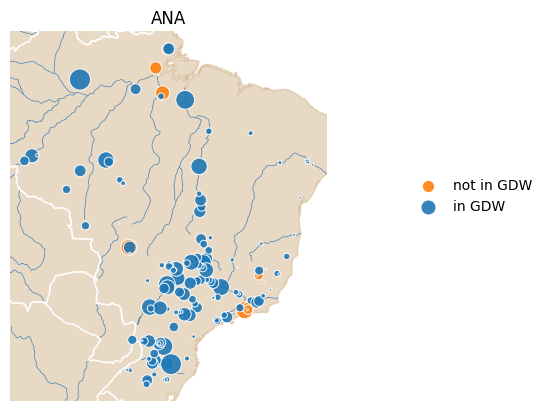

In [3]:
# load ANA reservoirs
ana = gpd.read_file(
    cfg.PATH_RESOPS / 'raw' / 'attributes' / 'SIN' / 'Sistema_de_Acompanhamento_de_Reservatorios_-_Sistema_Interligado_Nacional.shp'
).set_index('SAR_ID', drop=True)
ana.GRAND_ID = ana.GRAND_ID.astype('Int64')
ana.GDW_ID = ana.GDW_ID.astype('Int64')
ana.sort_index(axis=1, inplace=True)

mask_gdw = ana.GDW_ID.notnull()

print('ANA')
print('---')
print('Catalogue')
print('No. reservoirs:\t{0} ({2} in GDW)\nNo. attributes:\t{1}\n'.format(*ana.shape, mask_gdw.sum()))

fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='tan'), alpha=.5, zorder=0)
ax.add_feature(cfeature.BORDERS, edgecolor='w', lw=1.2, zorder=2)
ax.add_feature(cfeature.RIVERS, edgecolor='steelblue', lw=.5, zorder=1)
ana[~mask_gdw].plot(markersize=np.sqrt(ana.SAR_VO_MAX), c='C1', edgecolor='w', lw=.75, alpha=.9, ax=ax, zorder=10, label='not in GDW')
ana[mask_gdw].plot(markersize=np.sqrt(ana.SAR_VO_MAX), c='C0', edgecolor='w', lw=.75, alpha=.9, ax=ax, zorder=10, label='in GDW')
ax.set_title('ANA')
fig.legend(frameon=False, bbox_to_anchor=[1, .4, .1, .2])
ax.axis('off');

## GDW

GDW
-----
No. reservoirs:	5229
No. attributes:	74

1284 out of 5229 reservoirs exceed the minimum catchment area of 50 km2 (0 missing values)
930 out of 5229 reservoirs exceed the minimum reservoir volume of 10 hm3 (0 missing values)
641 out of 5229 reservoirs exceed the minimum catchment area (50 km2) and the minimum reservoir volume (10 hm3)


C:\DEV\Anaconda3\envs\reservoirs\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\DEV\Anaconda3\envs\reservoirs\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


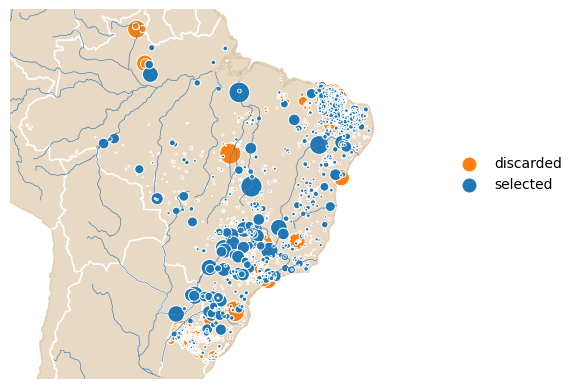

In [4]:
# load shapefile of dams
gdw = gpd.read_file(
    'Z:/nahaUsers/casadje/datasets/reservoirs/GDW/GDW_v1_0_shp/GDW_barriers_v1_0.shp'
).set_index('GDW_ID', drop=False)

# filter dams in Brazil
gdw = gdw.loc[gdw.COUNTRY.str.lower().isin(['brazil', 'paraguay'])]

# correct names
gdw.DAM_NAME = gdw.DAM_NAME.str.upper()
gdw.RES_NAME = gdw.RES_NAME.str.upper()
gdw.ADMIN_UNIT = gdw.ADMIN_UNIT.str.upper()

# rename columns
gdw['LON'] = gdw.geometry.x
gdw['LAT'] = gdw.geometry.y

print('GDW')
print('-----')
print('No. reservoirs:\t{0}\nNo. attributes:\t{1}\n'.format(*gdw.shape))

# select reservoirs based on catchment area and reservoir volume
mask_gdw = filter_reservoirs(gdw.CATCH_SKM, gdw.CAP_MCM, cfg.MIN_AREA, cfg.MIN_VOL)

fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='tan'), alpha=.5, zorder=0)
ax.add_feature(cfeature.BORDERS, edgecolor='w', lw=1.2, zorder=1)
ax.add_feature(cfeature.RIVERS, edgecolor='steelblue', lw=.5, zorder=2)
gdw.loc[~mask_gdw].plot(markersize=np.sqrt(gdw.CAP_MCM), c='C1', edgecolor='w', lw=.75, ax=ax, label='discarded')
gdw.loc[mask_gdw].plot(markersize=np.sqrt(gdw.CAP_MCM), c='C0', edgecolor='w', lw=.75, ax=ax, label='selected')
fig.legend(frameon=False, bbox_to_anchor=[1, .4, .1, .2])
ax.axis('off');

# apply the selection
# gdw = gdw.loc[mask_gdw]

### Connect ANA and GDW

I've done the connection manually in GIS.

In [5]:
# keep ANA reservoirs with GRanD ID
ana = ana[ana.GDW_ID.notnull()]
ana.reset_index(inplace=True)
ana.set_index('GDW_ID', drop=True, inplace=True)

In [6]:
# keep GDW reservoirs in SIN
gdw = gdw.loc[ana.index]

### Reservoir use

In [7]:
# rename columns
rename_uses_gdw = {
    'USE_IRRI': 'IRRIGATION',
    'USE_ELEC': 'HYDROPOWER',
    'USE_SUPP': 'SUPPLY',
    'USE_FCON': 'FLOOD',
    'USE_RECR': 'RECREATION',
    'USE_NAVI': 'NAVIGATION',
    'USE_FISH': 'FISH',
    'USE_PCON': 'POLLUTION',
    'USE_LIVE': 'LIVESTOCK',
    'USE_OTHR': 'OTHER'
}
gdw.rename(columns=rename_uses_gdw, inplace=True)

# replace values in 'MAIN_USE' to be consistent with the columns
gdw.MAIN_USE.replace({
    'Irrigation': 'IRRIGATION',
    'Hydroelectricity': 'HYDROPOWER',
    'Water supply': 'SUPPLY',
    'Other': 'OTHER',
    'Recreation': 'RECREATION',
    'Flood control': 'FLOOD'
}, inplace=True)

# convert to boolean
gdw_uses = list(rename_uses_gdw.values())
gdw[gdw_uses] = gdw[gdw_uses].replace({'Main': True, 'Major': True, 'Sec': True, None: False})

# identify single purpose reservoirs
gdw['SINGLE_USE'] = False
mask_singleuse = gdw[gdw_uses].sum(axis=1) == 1
gdw.loc[mask_singleuse, 'SINGLE_USE'] = True

**Main use**

In [8]:
mask_singleuse = gdw.SINGLE_USE
mask_hdcc = ~gdw.index.isnull()

mainuse_singlepurpose = gdw.loc[mask_hdcc & mask_singleuse, 'MAIN_USE'].value_counts()
mainuse_multipurpose = gdw.loc[mask_hdcc, 'MAIN_USE'].value_counts()
mainuse_summary_gdw = pd.concat((mainuse_singlepurpose, mainuse_multipurpose), axis=1)
mainuse_summary_gdw.columns = ['singlepurpose', 'multipurpose']
mainuse_summary_gdw.sort_values('multipurpose', ascending=False, inplace=True)
del mainuse_singlepurpose, mainuse_multipurpose

**All uses**

In [9]:
alluses_singlepurpose = gdw.loc[mask_hdcc & mask_singleuse, gdw_uses].sum()
alluses_multipurpose = gdw.loc[mask_hdcc, gdw_uses].sum()
alluses_summary_gdw = pd.concat((alluses_singlepurpose, alluses_multipurpose), axis=1)
alluses_summary_gdw.columns = ['singlepurpose', 'multipurpose']
alluses_summary_gdw.sort_values('multipurpose', ascending=False, inplace=True)
alluses_summary_gdw.dropna(axis=0, how='all', inplace=True)
alluses_summary_gdw = alluses_summary_gdw[~(alluses_summary_gdw == 0).all(axis=1)]
del alluses_singlepurpose, alluses_multipurpose

## Export

In [14]:
# convert boolean fields to 0-1
bool_cols = list(rename_uses_gdw.values()) + ['SINGLE_USE']
gdw[bool_cols] = gdw[bool_cols].astype(bool).astype(int)

# attributes to be included from GDW
gdw.columns = gdw.columns.str.upper()
cols_gdw = [
    'RES_NAME', 
    'DAM_NAME', 
    'YEAR_DAM', 
    'REM_YEAR', 
    'LON', 
    'LAT',
    'DAM_HGT_M', 
    'DAM_LEN_M', 
    'AREA_SKM', 
    'CAP_MCM', 
    'DEPTH_M', 
    'DIS_AVG_LS', 
    'DOR_PC', 
    'ELEV_MASL', 
    'CATCH_SKM',
    'IRRIGATION', 
    'HYDROPOWER', 
    'SUPPLY', 
    'FLOOD', 
    'RECREATION', 
    'NAVIGATION', 
    'FISH', 
    'POLLUTION', 
    'LIVESTOCK', 
    'OTHER', 
    'MAIN_USE', 
    'SINGLE_USE',
    'LAKE_CTRL'
]

# export as CSV
gdw[cols_gdw].to_csv(cfg.PATH_ATTRS / 'gdw.csv')

# export SIN attributes
cols_ana = [
    'GRAND_ID',
    'SAR_ID',
    'SAR_NM',
    'CBF_NM',
    'SAR_NM_BAC',
    'SAR_NM_MUN',
    'SAR_NM_UF',
    'SAR_SG_UF',
    'SAR_NU_LAT',
    'SAR_NU_LON',
    'SAR_CO_MIN',
    'SAR_CO_MAX',
    'SAR_VO_MIN',
    'SAR_VO_MAX',
    'SAR_VO_UTI',
    'SAR_TP_RES',
    'SAR_TP_SIS'
]
ana[cols_ana].sort_index().to_csv(cfg.PATH_ATTRS / 'ana.csv', encoding='utf-8')

## Ancillary data

#### `lfcoords`

In [23]:
path_lfcoords = cfg.PATH_RESOPS / 'ancillary' / 'lfcoords'
path_lfcoords.mkdir(parents=True, exist_ok=True)
filename = 'dams_gdw'

In [21]:
# select reservoirs
# mask = filter_reservoirs(grand.CATCH_SKM, grand.CAP_MCM, MIN_AREA, MIN_VOL)
cols = ['LAT', 'LON', 'CATCH_SKM']
mask = gdw[cols].notnull().any(axis=1)

# create input CSV for `lfcoords`
lfcoords = gdw.loc[mask, cols].copy()
lfcoords.index.name = 'ID'
lfcoords.columns = ['lat', 'lon', 'area']
lfcoords.sort_index(inplace=True)
lfcoords.to_csv(path_lfcoords / f'{filename}.csv')

#### `cutmaps`

In [26]:
path_cutmaps = cfg.PATH_RESOPS / 'ancillary' / 'cutmaps'
path_cutmaps.mkdir(parents=True, exist_ok=True)

for basin in ['amazon', 'north_east', 'north', 'parana']:
    # prepare TXT file
    points = gpd.read_file(path_lfcoords / basin / f'{filename}_3min.shp')
    points['lon'] = points.geometry.x
    points['lat'] = points.geometry.y
    points.rename(columns={'ID': 'id'}, errors='ignore', inplace=True)

    # export TXT file
    points[['lon', 'lat', 'id']].to_csv(
        path_cutmaps / f'{filename}_{basin}.txt',
        sep='\t',
        header=False,
        index=False,
        float_format='%.6f'
    )

#### `ncextract`

In [74]:
path_ncextract = PATH_RESOPS / 'ancillary' / 'ncextract'
path_ncextract.mkdir(parents=True, exist_ok=True)

points[['id', 'lat', 'lon']].to_csv(
    path_ncextract / 'reservoirs.csv',
    header=True,
    index=False,
    float_format='%.4f'
)